<div style='text-align: right; font-family:TimesNewRoman'>
    January 2026
</br>
    Enrico Minguzzi
</br>
    Manuel Barbieri
</div>

<h1 style='font-family:TimesNewRoman'>Product Classification with CNNs</h1> 

<div style='text-align: justify; font-family:TimesNewRoman'>
This project presents the development and evaluation of convolutional neural networks (CNNs) for the classification of smartphone pictures of grocery store products. The notebook is structured as a combination of explanatory text and executable code, documenting both the methodological choices and the experimental results.</br></br>The work is divided into three main sections:    
    <ul style='list-style: none;'>
        <li>
            <h3>1. Design and implementation of a CNN from scratch</h3>
            A custom convolutional network is built using basic Keras layers. Starting from a simple baseline architecture, the model is progressively refined through actions on the network layout, the hyperparameters and the dataset. Said choices are motivated before they're implemented, and their impact is discussed after the results have been shown. This step is to be considered completed once a validation accuracy of at least 60% is achieved.
        </li>
        <li>
            <h3>2. Fine-tuning of a pre-trained network</h3>
            A deep ResNet-based architecture pre-trained on a large-scale dataset and provided by Keras is adapted to the target task through transfer learning. By leveraging pre-trained features and adjusting the training strategy, the goal is to significantly improve performance, reaching a validation accuracy of at least 80%.
        </li>
        <li>
            <h3>3. Final evaluation and comparison</h3>
            In the last section, the best-performing models of the two previous steps are evaluated on the test dataset. Their results are compared side by side, highlighting differences in accuracy and generalisation capabilities.
        </li>
    </ul>
</div>

<h2 style='font-family:TimesNewRoman'>Dataset</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>
The dataset in this project is sourced from a publicly available <a href="https://github.com/marcusklasson/GroceryStoreDataset.git">GitHub repository</a> and consists of natural pictures (i.e. RGB) of grocery store products captured using smartphone cameras in real-world environments. It is already split into training, validation and test datasets.</br></br>The dataset contains approximately 5125 pictures belonging to a wide range of product categories, including fruits, vegetables and packaged items such as milk and juice. Each picture is annotated using both a fine-grained and a coarse-grained labelling scheme, comprising 81 and 43 classes respectively. For example, a product may be labelled with a coarse-grained category such as `milk`, and a corresponding fine-grained label such as `Arla-Lactose-Free-Milk`.</br></br>In this project, only the coarse-grained labels are considered. As a result, the classification task focuses on distinguishing between general product categories rather than between specific brands or product variants.</br></br>In this first block of code, the necessary dependencies are imported, and the preliminary setting is done:
</div>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras
import pandas as pd
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ["KERAS_BACKEND"] = "tensorflow"
seed = 42
keras.utils.set_random_seed(seed)
np.random.seed(seed)

C:\Users\Manuel\AppData\Roaming\Python\Python312\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


<div style='text-align: justify; font-family:TimesNewRoman'>
The dataset is then loaded from the local directory in which it has been downloaded. To exactly replicate the execution environment used in this notebook, the `GroceryStoreDataset` folder should be placed at the same directory level as the folder containing this notebook, so that it can be accessed from this file through the following relative path: `..\GroceryStoreDataset`.</br></br>The dataset directory contains three text files (`train.txt`, `validation.txt` and `test.txt`), which define the corresponding dataset splits. Each file lists the relative paths to the pictures belonging to that dataset, together with their associated class labels. The datasets are constructed by iterating over these files, parsing each line and extracting the relevant information needed to load the pictures and assign the correct labels.</br></br>Although Keras provides built-in utilities for creating image datasets directly from directory structure, this approach is not particularly convenient in this case. Due to the organisation of the dataset, using such utilities would require creating multiple subsets of the dataset independently (e.g. `fruit_test`, `packages_test`, etc.) and then manually merging them into unified training, validation and test datasets. This process would also introduce additional complexity in terms of label handling, as class indices would be defined locally within each subset. Consequently, careful label remapping would be necessary to ensure consistency. Without it, class ID 0 in `fruit-train` would correspond to class ID 0 in `vegetables_train` and to class ID 0 in `packages-train`, and so on for every class ID and every dataset.</br></br>Given the dataset contains pictures of different spatial dimensions, they're resized to 256×256 pixels.
</div>

In [2]:
# BASIC DATA LOAD (ratio not preserved)

def basic_load(url_directory, url_file, resizeX=256, resizeY=256):
    X = []
    y = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, (resizeX, resizeY))
            X.append(img_resized)
            y.append(int(line_split[2].strip()))

    return np.stack(X, axis=0), np.array(y)

In [3]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_val = []
y_val = []

X_test = []
y_test = []

X_train, y_train = basic_load(url_directory, "train.txt")
X_val, y_val = basic_load(url_directory, "val.txt")
X_test, y_test = basic_load(url_directory, "test.txt")

<div style='text-align: justify; font-family:TimesNewRoman'>
Lastly, the provided `.csv` file is used to import the complete list of product classes names, together with their corresponding numerical identifiers. All references to a product's ID class in the following sections of the notebook adhere to this mapping.
</div>

In [4]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)

In [5]:
print(f"The shape of the training set is {X_train.shape}")
print(f"The shape of the validation set is {X_val.shape}")
print(f"The shape of the testing set is {X_test.shape}")

The shape of the training set is (2640, 256, 256, 3)
The shape of the validation set is (296, 256, 256, 3)
The shape of the testing set is (2485, 256, 256, 3)


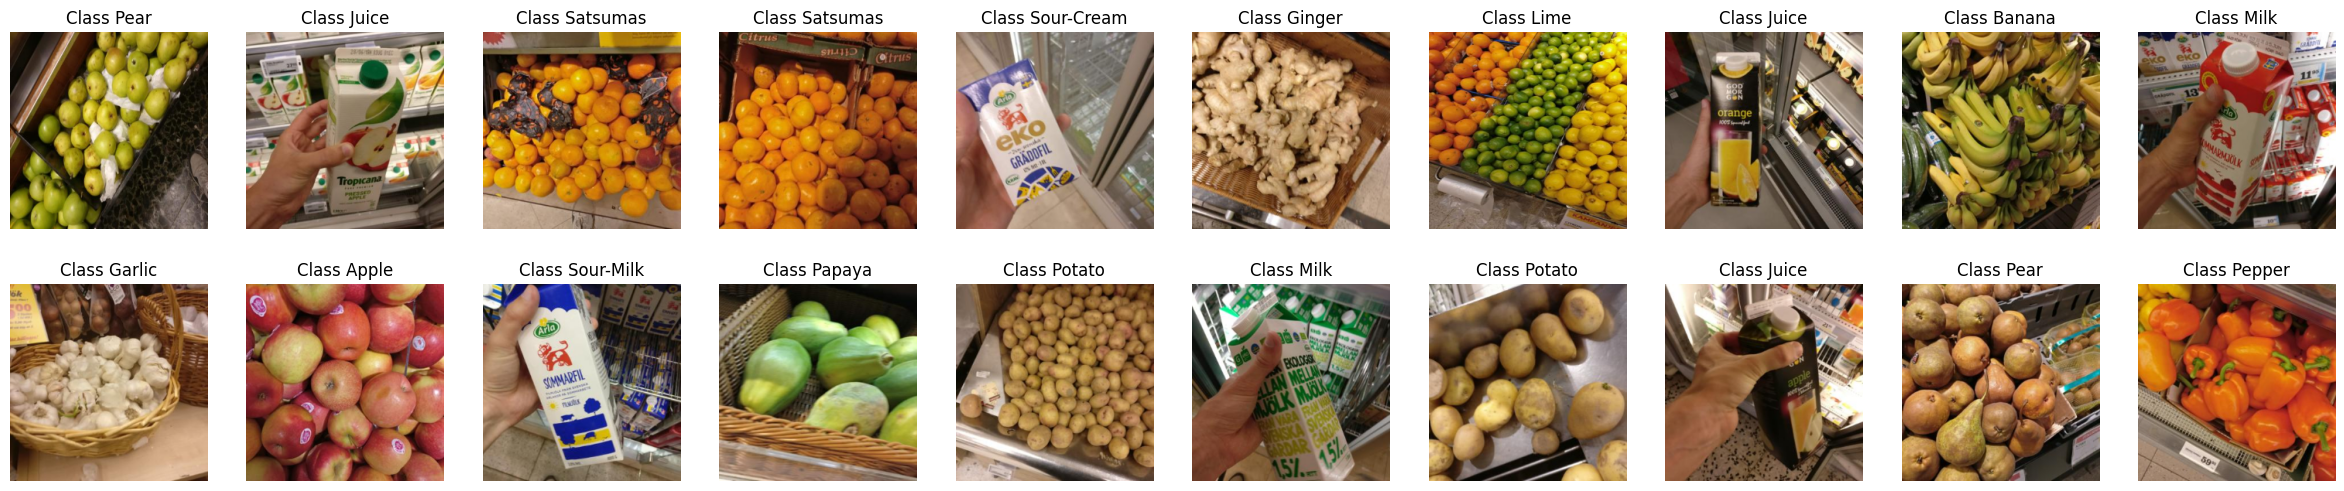

In [6]:
fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train[rand_idx], cv2.COLOR_BGR2RGB))

<h1 style='font-family:TimesNewRoman'>1. Building a network from scratch</h1>

<div style='text-align: justify; font-family:TimesNewRoman'>
In this first phase of the project, only the training and validation splits are used, for a total of approximately 3.000 pictures. The test set is intentionally left untouched and reserved for the final evaluation.</br></br>The first iteration of the CNN is deliberately kept as simple as possible. No preprocessing steps, such as data normalisation or data augmentation, are applied at this stage. This baseline configuration allows for a clearer assessment of the model's inherent capacity and provides a starting point.</br>
</div>

<h2 style='font-family:TimesNewRoman'>1.1 First Iteration — Basic</h2> 

<div style='text-align: justify; font-family:TimesNewRoman'>
The baseline model consists of a minimal convolutional architecture inspired by the network introduced during the laboratory session. It is composed of three main learnable layers: two convolutional layers with 3x3 kernels, followed by a fully connected layer responsible for the final classification.</br></br>The convolutional layers are configured with a stride of 1 and appropriate padding to preserve the spatial resolution of the feature maps. Spatial downsampling is instead achieved through max-pooling operations applied after each convolutional layer. As the spatial dimensions of the activations are progressively reduced, the number of channels is increased.</br></br>The following code snippet shows the network definition, along with the corresponding model summary.
</div>

In [7]:
# MODEL DEFINITION

from keras import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, Flatten

input_shape = X_train.shape[1:]

model = Sequential(
    [   
        # Input layer.
        Input(shape = input_shape),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 128, 128, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 262144)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 43)                  │      11,272,235 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,291,627 (43.07 MB)

 Trainable params: 11,291,627 (43.07 MB)

 Non-trainable params: 0 (0.00 B)

<div style='text-align: justify; font-family:TimesNewRoman'>
Then, the model training:
</div>

In [8]:
# MODEL TRAINING

from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 64 #128
epochs = 8
val_split_percentage = 0.25

model.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model.fit(
    X_train, 
    y_train,
    batch_size = batch_size, 
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 768ms/step - accuracy: 0.1595 - loss: 99.9159 - val_accuracy: 0.1791 - val_loss: 3.5472
Epoch 2/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 42s 787ms/step - accuracy: 0.6348 - loss: 1.4640 - val_accuracy: 0.1081 - val_loss: 4.9205
Epoch 3/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 761ms/step - accuracy: 0.9144 - loss: 0.3673 - val_accuracy: 0.1858 - val_loss: 7.6673
Epoch 4/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 796ms/step - accuracy: 0.9773 - loss: 0.0795 - val_accuracy: 0.1486 - val_loss: 8.4877
Epoch 5/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 40s 758ms/step - accuracy: 0.9939 - loss: 0.0458 - val_accuracy: 0.1149 - val_loss: 11.8758
Epoch 6/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 33s 789ms/step - accuracy: 0.9792 - loss: 0.0900 - val_accuracy: 0.1149 - val_loss: 9.2634
Epoch 7/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 739ms/step - accuracy: 0.9955 - loss: 0.0220 - val_accuracy: 0.0912 - val_loss: 11.2800
Epoch 8/8
42/42 ━━━━━━━━━━━━━━━━━━━━ 31s 749ms/step - accuracy: 0.9985 - loss: 0.0086 - val_accuracy:

<div style='text-align: justify; font-family:TimesNewRoman'>
The results obtained by this initial attempt show a very low accuracy on the validation set (~15%), while the training accuracy reached the 100% threshold. The large discrepancy between these accuracy values is an indication of overfitting: the model is memorising the training samples, rather than learning generalised features.</br>Such behaviour can typically be attributed to either an excessively high model capacity or to an insufficient amount of elements and variability in the training data.
</div>

<h2 style='font-family:TimesNewRoman'>1.2 Second iteration — Data Augmentation</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>
To address the overfitting observed in the baseline model, data augmentation is introduced into the training pipeline. By applying random transformations to the input images, the overall diversity of the dataset is increased.
First, though, through the `Rescaling layer` provided by Keras, the pictures are normalised so that their values belongs to the interval [0, 1].</br></br>It is worth noting that Keras provides additional built-in layers for data augmentation. However, preliminary experiments using these layers led to underfitting. Unlike handmade augmentation techniques that explicitly increase the size of the training set, Keras augmentation layers apply random transformations to each image on the fly, just before it is fed to the model during training. As a result, the effective dataset size remains unchanged. While this approach guarantees a high degree of variability across epochs, it also makes the learning task more challenging. Since the model is rarely exposed to the exact image twice, convergence can be slower, particularly when the base dataset is relatively small. For these reasons, an alternative augmentation strategy is used. </br></br>The augmentation employed takes inspiration from the one seen for AlexNet. It aims to increase the size of the dataset and introduce variability, rather than simply applying transformations. Hence, from each picture originally belonging to the dataset:
<ol>
        <li>
            A random crop of 224×224 is selected (hereafter referred to as `base picture`) → +0
        </li>
        <li>
            Centrally zooming `base picture`, obtaining `base zoomed` → +1
        </li>
        <li>
            Flipping of the `base picture`, obtaining `base flipped` → +1
        </li>
        <li>
            Cutout of a patch from `base flipped`, obtaining `base cut` → +1
        </li>
        <li>
            Contrast stretching and colour jittering on `base picture`, obtaining `altered picture` → +1
        </li>
        <li>
            Flipping of `altered picture`, obtaining `altered flipped` → +1
        </li>
        <li>
            Cutout of a patch from `altered flipped`, obtaining `altered cut` → +1
        </li>
</ol>
The size of the training dataset is increased by adding 6 alterations per picture originally present (~2.500). Hence, the resulting dataset is 7 times the original size, reaching ~17.500 pictures.</br></br>A point which sparked some confrontation involved the order in which colour jittering and contrast stretching were computed. Contrast stretching operates on the intensity distribution of a picture, normalising the contrast between light and dark areas. Colour jittering, on the other hand, introduces perturbations in brightness, contrast and saturation. It makes sense that the perturbations are applied after the picture's intensity distribution is normalised, or else the contrast stretching procedure may partially undo the random variations introduced by colour jittering.
</div>

In [2]:
# DEFINITION OF FUNCTIONS USED IN DATA AUGMENTATION PIPELINE

def color_jittering(img, brightness_range=(-60, 60), saturation_range=(-60, 60)):
    rng = np.random.default_rng()
    img_hsv = cv2.cvtColor(img.copy(), cv2.COLOR_BGR2HSV)

    brightness = rng.integers(brightness_range[0], brightness_range[1])
    saturation = rng.integers(saturation_range[0], saturation_range[1])

    img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1] + saturation, 0, 255)
    img_hsv[:, :, 2] = np.clip(img_hsv[:, :, 2] + brightness, 0, 255)

    img_hsv = img_hsv.astype(np.uint8)

    return cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)

def contrast_stretching(img, linear_contrast=True, gamma_correction=False, gamma_correction_parameter=1.0):
    img_copy = img.copy()
    
    if linear_contrast:
        p_min = np.percentile(img_copy, 5)
        p_max = np.percentile(img_copy, 95)

        img_copy = np.clip((255/(p_max - p_min)) * (img_copy - p_min), 0, 255).astype(np.uint8)

    if gamma_correction:
        img_copy = np.clip(255 * np.power(img_copy/255, gamma_correction_parameter), 0, 255).astype(np.uint8)

    return img_copy

def cutout(img, size=64, color=50):
    rng = np.random.default_rng()
    img_copy = img.copy()

    x = rng.integers(0, img.shape[0] - size)
    y = rng.integers(0, img.shape[1] - size)

    img_copy[x : x + size, y : y + size] = color
    return img_copy

def zoom(img, zoom_center=None, zoom_pixel=35):
    img_copy = img.copy()
    zoom_tot = img.shape[0] // 2 - zoom_pixel
    
    if zoom_center == None:
        cx = img_copy.shape[0] // 2
        cy = img_copy.shape[1] // 2
    else:
        cx = zoom_center[0]
        cy = zoom_center[1]
    
    pts1 = np.float32([(cx - zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy - zoom_tot), (cx + zoom_tot, cy + zoom_tot), (cx - zoom_tot, cy + zoom_tot)])
    pts2 = np.float32([(0, 0), (img_copy.shape[0], 0), (img_copy.shape[0], img_copy.shape[1]), (0, img_copy.shape[1])])
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(img_copy, M, (img.shape[0], img.shape[1]))
    
    return dst
    
def size_to_change(img, size):
    if img.shape[0] <= img.shape[1]:
        return (256, int(np.floor(256 / img.shape[0] * img.shape[1])))
    else:
        return (int(np.floor(256 / img.shape[1] * img.shape[0])), 256)

def get_random_crop(img, cropX=224, cropY=224):
    max_x = img.shape[0] - cropX
    max_y = img.shape[1] - cropY

    x = np.random.randint(0, max_x)
    y = np.random.randint(0, max_y)

    crop = img[x: x + cropX, y: y + cropY]
    
    return crop

# DATA LOADING FUNCTION (ALSO TAKES 224X224 CROPS)
def load_data(url_directory, url_file, size=256, crop_dim=224, random_crop=False, central_crop=False, return_original=False):
    X = []
    y = []
    X_original = []
    
    with open(url_directory + url_file) as f:
        for line in f:
            line_split = line.split(",")
            img = cv2.imread(url_directory + line_split[0])
            img_resized = cv2.resize(img, size_to_change(img, size))
            lbl = int(line_split[2].strip())

            if random_crop:
                crop = get_random_crop(img_resized, crop_dim, crop_dim)
            elif central_crop:
                img_center = (img_resized.shape[0] // 2, img_resized.shape[1] // 2)
                crop_dim_half = crop_dim // 2
                crop = img_resized[
                    img_center[0] - crop_dim_half : img_center[0] - crop_dim_half + crop_dim,
                    img_center[1] - crop_dim_half : img_center[1] - crop_dim_half + crop_dim
                    ]
            else:
                crop = img_resized[:crop_dim, :crop_dim]

            X.append(crop)
            y.append(lbl)

            if return_original:
                img_resized_original = img_resized[:size, :size]
                X_original.append(img_resized_original)

    X = np.stack(X, axis=0)
    y = np.array(y)

    if return_original:
        return X, y, np.stack(X_original, axis=0)
    else:
        return X, y

In [10]:
url_directory = "../GroceryStoreDataset/dataset/"

X_train = []
y_train = []

X_train, y_train, X_train_original = load_data(url_directory, "train.txt", random_crop=True, return_original=True)
X_val, y_val = load_data(url_directory, "val.txt")
X_test, y_test = load_data(url_directory, "test.txt")

In [11]:
df_classes = pd.read_csv(url_directory + "classes.csv")
df_coarse = df_classes.loc[:, ['Coarse Class Name (str)', 'Coarse Class ID (int)']].drop_duplicates().values
labels_coarse = {i: lbl for lbl, i in df_coarse}
n_classes_coarse = len(labels_coarse)
#labels_coarse

In [12]:
# DATA AUGMENTATION PIPELINE

X_train_augmented = []
y_train_augmented = []
n_crop = 1
rng = np.random.default_rng()

for idx, img in enumerate(X_train_original):
    lbl = y_train[idx]

    img_base = get_random_crop(img)
    X_train_augmented.append(img_base)
    y_train_augmented.append(lbl)

    img_base_zoom = zoom(img_base)
    X_train_augmented.append(img_base_zoom)
    y_train_augmented.append(lbl)

    if rng.integers(2) == 0: 
        img_base_flip = cv2.flip(img_base, 1)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)
    else:
        img_base_flip = cv2.flip(img_base, 0)
        X_train_augmented.append(img_base_flip)
        y_train_augmented.append(lbl)

    img_base_cutout = cutout(img_base_flip)
    X_train_augmented.append(img_base_cutout)
    y_train_augmented.append(lbl)

    for j in range(0, n_crop):
        img_new = get_random_crop(img)
        img_new = contrast_stretching(img_new)
        img_new = color_jittering(img_new)
        X_train_augmented.append(img_new)
        y_train_augmented.append(lbl)

        if rng.integers(2) == 0:
            img_new_flip = cv2.flip(img_new, 1)
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)
        else:
            img_new_flip = cv2.flip(img_new, 0)
            X_train_augmented.append(img_new_flip)
            y_train_augmented.append(lbl)

        img_new_cutout = cutout(img_new_flip)
        X_train_augmented.append(img_new_cutout)
        y_train_augmented.append(lbl)

X_train_augmented = np.stack(X_train_augmented, axis=0)
y_train_augmented = np.array(y_train_augmented)
print(X_train_augmented.shape, y_train_augmented.shape)

(18480, 224, 224, 3) (18480,)


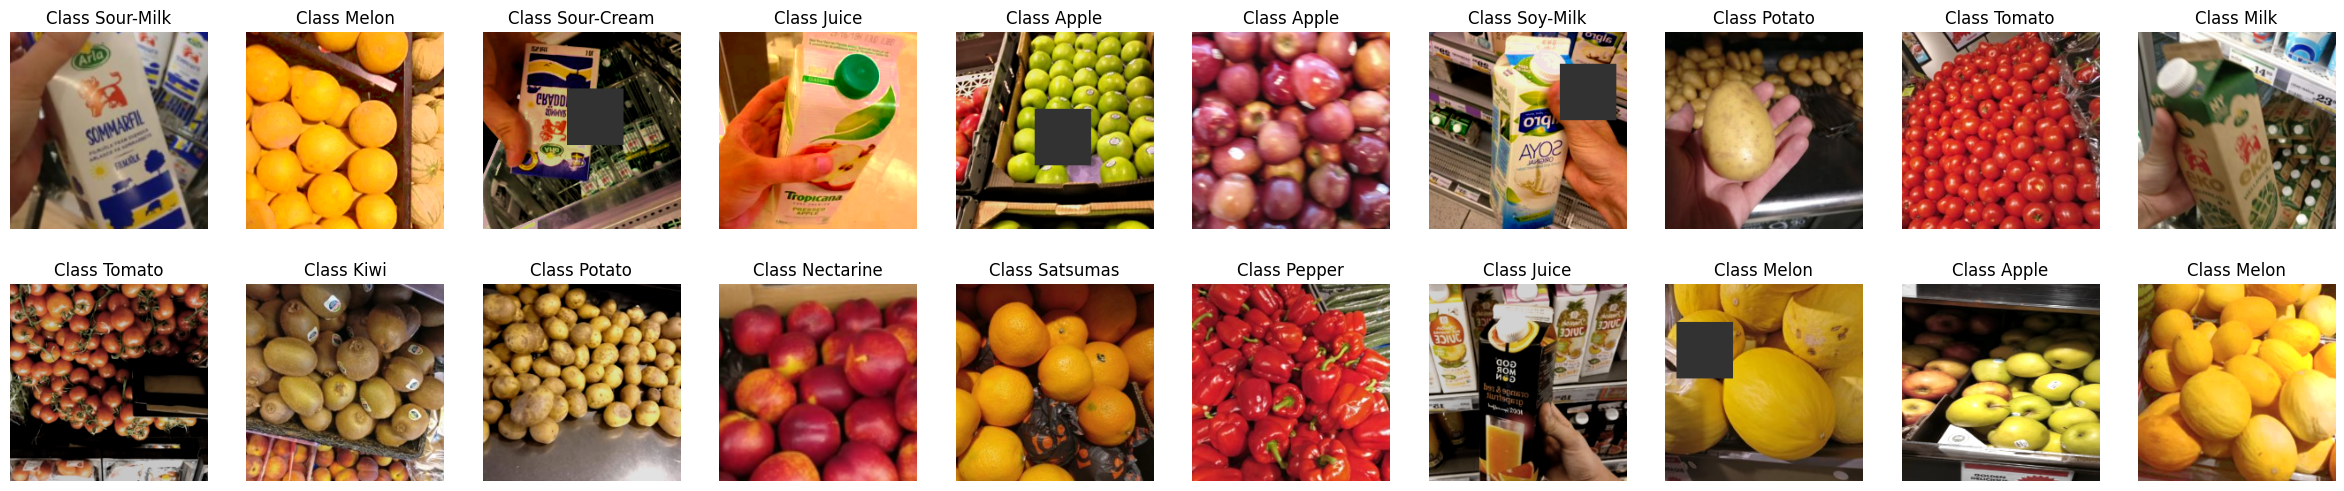

In [13]:
# DEBUG FUNCTION TO DISPLAY A FEW SAMPLES FROM THE AUGMENTED DATASET

fig, ax = plt.subplots(2, 10, figsize=(30, 6))
ax = ax.ravel()
for i in range(20):
    rand_idx = np.random.randint(0, X_train_augmented.shape[0])
    ax[i].set_axis_off()
    ax[i].set_title(f"Class {labels_coarse[y_train_augmented[rand_idx]]}")
    ax[i].imshow(cv2.cvtColor(X_train_augmented[rand_idx], cv2.COLOR_BGR2RGB))

In [14]:
# NEW MODEL (NOW HAS DATA NORMALISATION LAYER)

from keras.layers import Rescaling
input_shape = X_train_augmented.shape[1:]

model_augmented = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (2, 2)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_augmented.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 200704)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │       8,630,315 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,649,707 (33.00 MB)

 Trainable params: 8,649,707 (33.00 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# MODEL TRAINING

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 8
#val_split_percentage = 0.25

model_augmented.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_augmented.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 168s 290ms/step - accuracy: 0.5374 - loss: 1.6642 - val_accuracy: 0.3480 - val_loss: 3.2388
Epoch 2/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 201s 287ms/step - accuracy: 0.8933 - loss: 0.3484 - val_accuracy: 0.3446 - val_loss: 3.9562
Epoch 3/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 203s 289ms/step - accuracy: 0.9641 - loss: 0.1267 - val_accuracy: 0.3784 - val_loss: 4.1510
Epoch 4/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 168s 291ms/step - accuracy: 0.9819 - loss: 0.0656 - val_accuracy: 0.3378 - val_loss: 4.7903
Epoch 5/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 197s 283ms/step - accuracy: 0.9859 - loss: 0.0472 - val_accuracy: 0.3108 - val_loss: 5.5366
Epoch 6/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 164s 284ms/step - accuracy: 0.9847 - loss: 0.0517 - val_accuracy: 0.3209 - val_loss: 6.0923
Epoch 7/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 173s 300ms/step - accuracy: 0.9882 - loss: 0.0409 - val_accuracy: 0.3007 - val_loss: 6.6243
Epoch 8/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 192s 283ms/step - accuracy: 0.9887 - loss: 0

<h2 style='font-family:TimesNewRoman'>1.3 Third iteration — Network tweaking</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>
The introduction of data augmentation and normalisation alone has more than doubled the validation accuracy, hitting an average of approximately 30%. The data augmentation pipeline is now coherent and effective, potentially improving performance once the network becomes more sophisticated. An effective strategy would be further pursuing techniques to increase the size of the dataset; however, almost all the commonly used augmentation transformations have already been applied. For this reason, the focus is shifted to tweaking the network itself.</br></br>At this stage, the network layers remain overly simplistic and not suited for the product classification task. The current design is directly inspired by a lab session where the resolution of the input pictures was 28×28, gradually downsampled to 7×7 before reaching the FC layer through two 2×2 pooling steps. </br> In the current project, instead, the inputs are 224×224, meaning the two pooling layers only downsample them to 56×56, which implies an insufficient increase of the receptive field. To address this, the kernel size of the max-pooling layers was doubled (i.e. 4×4), meaning the activation would reach a spatial size of 14×14 before travelling into the final FC layer.</br></br>Since the data loading and augmentation are left unchanged, only the new model architecture and its training follow:
</div>

In [16]:
# NEW MODEL (NOW HAS INCREASED DOWNSAMPLING)

input_shape = X_train_augmented.shape[1:]

model_dwsm = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),

        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_dwsm.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 43)                  │         539,435 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 558,827 (2.13 MB)

 Trainable params: 558,827 (2.13 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
# MODEL TRAINING

opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 8
#val_split_percentage = 0.25

model_dwsm.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_dwsm.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - accuracy: 0.5000 - loss: 1.6971 - val_accuracy: 0.3986 - val_loss: 2.3655
Epoch 2/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 70s 120ms/step - accuracy: 0.7880 - loss: 0.6806 - val_accuracy: 0.4493 - val_loss: 2.3846
Epoch 3/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 71s 122ms/step - accuracy: 0.8902 - loss: 0.3535 - val_accuracy: 0.4595 - val_loss: 2.8643
Epoch 4/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 72s 125ms/step - accuracy: 0.9377 - loss: 0.2080 - val_accuracy: 0.3953 - val_loss: 3.7368
Epoch 5/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 80s 122ms/step - accuracy: 0.9614 - loss: 0.1324 - val_accuracy: 0.4493 - val_loss: 3.8701
Epoch 6/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 81s 120ms/step - accuracy: 0.9709 - loss: 0.0965 - val_accuracy: 0.4426 - val_loss: 3.8507
Epoch 7/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.9761 - loss: 0.0775 - val_accuracy: 0.3919 - val_loss: 4.1024
Epoch 8/8
578/578 ━━━━━━━━━━━━━━━━━━━━ 69s 119ms/step - accuracy: 0.9789 - loss: 0.0664 - 

<div style='text-align: justify; font-family:TimesNewRoman'>
The result shows an increase in validation accuracy of roughly 10%, reaching the 40% threshold, which proves the model has been struggling due to a low receptive field. Following this discovery, it became logical to wonder whether the current downsampling was enough or if even better performance could be achieved by increasing it. Here is a brief table to showcase the results obtained by keeping the same network topography and increasing the kernel size of the final pooling step:
<table>
    <tr>
        <th style='text-align: center;'>Final pooling kernel size</th>
        <th style='text-align: center;'>Output shape before flattening layer (w, h, c)</th>
        <th style='text-align: center;'>Validation Accuracy</th>
    </tr>
    <tr>
        <td style='text-align: center;'>4x4</td>
        <td style='text-align: center;'>(14, 14, 64)</td>
        <td style='text-align: center;'>44%</td>
    </tr>
    <tr>
        <td style='text-align: center;'>8x8</td>
        <td style='text-align: center;'>(7, 7, 64)</td>
        <td style='text-align: center;'>47%</td>
    </tr>
    <tr>
        <td style='text-align: center;'>16x16</td>
        <td style='text-align: center;'>(3, 3, 64)</td>
        <td style='text-align: center;'>50%</td>
    </tr>
</table>
The final configuration obtained in the previous step proves to be the most promising. As a result, all subsequent network variants adhere to the design principle of reducing the spatial resolution of the activations to 3×3 before the flattening step.</br></br>The next phase of the experimentation focuses on gradually increasing the complexity of the network, hopefully approaching the target validation accuracy of 60%. To better compare the learning dynamics of the different models, the training duration is extended to 25 epochs for all the following experiments.</br></br>The first network variation modifies the downsampling strategy by splitting the final 16×16 pooling into two consecutive 4×4 pooling layers, interleaved by an additional convolutional layer. This should allow for a less abrupt reduction of the spatial resolution, while also increasing the depth of the network. The model definition and the corresponding training are reported below.
</div>

In [18]:
# FIRST TWEAKING STEP

input_shape = X_train_augmented.shape[1:]

model_v1 = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),


        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_v1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 3, 3, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          49,579 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,827 (557.92 KB)

 Trainable params: 142,827 (557.92 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 25
#val_split_percentage = 0.25

model_v1.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_v1.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 74s 127ms/step - accuracy: 0.3980 - loss: 2.0400 - val_accuracy: 0.3581 - val_loss: 2.3757
Epoch 2/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 73s 126ms/step - accuracy: 0.6840 - loss: 0.9815 - val_accuracy: 0.5034 - val_loss: 2.3205
Epoch 3/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 73s 126ms/step - accuracy: 0.7976 - loss: 0.6129 - val_accuracy: 0.5405 - val_loss: 2.3539
Epoch 4/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.8626 - loss: 0.4179 - val_accuracy: 0.5642 - val_loss: 2.3721
Epoch 5/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.8988 - loss: 0.3104 - val_accuracy: 0.5372 - val_loss: 2.8814
Epoch 6/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.9207 - loss: 0.2398 - val_accuracy: 0.5507 - val_loss: 2.9203
Epoch 7/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 73s 126ms/step - accuracy: 0.9397 - loss: 0.1787 - val_accuracy: 0.5034 - val_loss: 3.6765
Epoch 8/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 82s 126ms/step - accuracy: 0.9501 - loss: 0

<div style='text-align: justify; font-family:TimesNewRoman'>
Following the first set of improvements, the model reaches a validation accuracy of approximately 52% at the 25th epoch, while maintaining a training accuracy close to 98%, resulting in a modest performance gain.</br></br>In the subsequent iteration, the depth of the network is further increased. Once the receptive field has been successfully expanded (corresponding to a spatial activation of size 14×14), a block of three convolutional layers is introduced. This choice is inspired by the architecture of AlexNet, where multiple convolutional layers are stacked at deeper stages of the network to enable learning more global features.</br></br>Furthermore, the number of channels is increased to 256 in the final convolutional layers. This should allow thenetwork to capture a denser set of high-level features once the spatial resolution has been sufficiently reduced.</div>

In [20]:
# SECOND TWEAKING STEP

input_shape = X_train_augmented.shape[1:]

model_v2 = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),


        # Classification head.
        Flatten(),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_v2.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 43)                  │          99,115 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,077,611 (4.11 MB)

 Trainable params: 1,077,611 (4.11 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 25
#val_split_percentage = 0.25

model_v2.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_v2.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 127s 218ms/step - accuracy: 0.3483 - loss: 2.2452 - val_accuracy: 0.4122 - val_loss: 2.4690
Epoch 2/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 141s 217ms/step - accuracy: 0.6572 - loss: 1.0443 - val_accuracy: 0.4189 - val_loss: 2.4442
Epoch 3/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 126s 217ms/step - accuracy: 0.7861 - loss: 0.6343 - val_accuracy: 0.4831 - val_loss: 2.8155
Epoch 4/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 144s 220ms/step - accuracy: 0.8643 - loss: 0.3971 - val_accuracy: 0.5304 - val_loss: 3.0575
Epoch 5/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 147s 228ms/step - accuracy: 0.9015 - loss: 0.2888 - val_accuracy: 0.5203 - val_loss: 3.8560
Epoch 6/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 142s 228ms/step - accuracy: 0.9292 - loss: 0.2053 - val_accuracy: 0.5405 - val_loss: 3.4167
Epoch 7/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 129s 223ms/step - accuracy: 0.9434 - loss: 0.1678 - val_accuracy: 0.5236 - val_loss: 4.2517
Epoch 8/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 144s 227ms/step - accuracy: 0.9522 -

<div style='text-align: justify; font-family:TimesNewRoman'>
The second architectural adjustment results in a further, although modest, improvement in performance. By the 25th training epoch, the model reaches a training accuracy of approximately 98%, while the validation accuracy increases to around 54%.</br></br> Although the results indicate better generalisation compared to the previous iteration, the target performance has not yet been achieved. Consequently, additional modifications are applied to the final part of the network, involving the fully connected layers.</br></br>In this iteration, the traditional flattening operation is replaced with global average pooling (GAP). This choice significantly reduces the number of trainable parameters by collapsing each feature map into a single representative value. Compared to flattening, GAP encourages the network to focus on the presence of discriminative features rather than their exact spatial location.</br>Additionally, a dropout mechanism is introduced after the GAP operation. Dropout randomly deactivates a fraction of the neurons during training, preventing the network from relying entirely on specific activations and promoting more robust learning.
</div>

In [22]:
# THIRD VARIATION

from keras.layers import GlobalAveragePooling2D, Dropout

input_shape = X_train_augmented.shape[1:]

model_v3 = Sequential(
    [   
        # Input layer.
        Input(shape=input_shape),
        Rescaling(1./255),

        # Convolutions with subsequent pooling.
        Conv2D(filters = 32, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 64, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),
        Conv2D(filters = 128, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        Conv2D(filters = 256, kernel_size = (3, 3), activation = "relu", padding = 'same'),
        MaxPooling2D(pool_size = (4, 4)),


        # Classification head.
        GlobalAveragePooling2D(),
        Dropout(0.35),
        Dense(units = n_classes_coarse, activation = "softmax")
    ]
)

model_v3.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_4 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 56, 56, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 14, 14, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 14, 14, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 989,547 (3.77 MB)

 Trainable params: 989,547 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
opt = Adam(learning_rate = 1e-3)
loss_fcn = SparseCategoricalCrossentropy()
batch_size = 32 #128
epochs = 25
#val_split_percentage = 0.25

model_v3.compile(
    loss = loss_fcn,
    optimizer = opt, 
    metrics = ["accuracy"]
) 

model_v3.fit(
    X_train_augmented,
    y_train_augmented,
    batch_size=batch_size,
    epochs = epochs, 
    validation_data = (X_val, y_val)
);

Epoch 1/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 141s 241ms/step - accuracy: 0.2718 - loss: 2.5449 - val_accuracy: 0.3345 - val_loss: 2.3853
Epoch 2/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 136s 235ms/step - accuracy: 0.5014 - loss: 1.5618 - val_accuracy: 0.4088 - val_loss: 2.3851
Epoch 3/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 142s 235ms/step - accuracy: 0.6369 - loss: 1.0977 - val_accuracy: 0.4831 - val_loss: 2.0260
Epoch 4/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 136s 236ms/step - accuracy: 0.7201 - loss: 0.8372 - val_accuracy: 0.5439 - val_loss: 1.9953
Epoch 5/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 144s 240ms/step - accuracy: 0.7894 - loss: 0.6306 - val_accuracy: 0.5169 - val_loss: 1.8743
Epoch 6/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 135s 233ms/step - accuracy: 0.8365 - loss: 0.4891 - val_accuracy: 0.5743 - val_loss: 2.1560
Epoch 7/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 128s 221ms/step - accuracy: 0.8698 - loss: 0.3871 - val_accuracy: 0.5473 - val_loss: 2.1224
Epoch 8/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 142s 221ms/step - accuracy: 0.8956 -

<div style='text-align: justify; font-family:TimesNewRoman'>
This network configuration is sufficient to achieve a validation accuracy of about 62m, successfully surpassing the target threshold set for this phase of the project. With this result, the first step of designing and training a CNN from scratch is considered complete.</br></br>While the obtained performance satisfies the purposes of this task, several additional strategies could be explored to further improve accuracy. For example, the introduction of more advanced regularisation techniques (e.g. batch normalisation) and the tuning of the hyperparameters (e.g. learning rate). Increasing model depth could also yield better performance, although this might also imply increasing the `batch_size` variable to speed up the training computations.
</div>

<h1 style='font-family:TimesNewRoman'>2. Fine-tuning of a pre-trained network</h1>

<div style='text-align: justify; font-family:TimesNewRoman'>
In the second part of this project, the focus shifts to leveraging transfer learning through the fine-tuning of a pre-trained architecture. Transfer learning is a widely adopted strategy, as it allows models to reuse feature representations learned from large-scale image collections not necessarily tied to the task at hand.</br></br>Specifically, a ResNet-18 architecture pre-trained on ImageNet-1K is employed through Keras as an off-the-shelf model. The fine-tuning process is divided into two distinct stages. In the first, the pre-trained model is adapted to the Grocery Store Dataset using the same training hyperparameters that yielded the best results in the previous section. In the second stage, the training configuration is refined to maximise validation accuracy. Hyperparameters, such as learning rate, optimisation strategy, and training dynamics, are adjusted until a validation accuracy of at least 80% is achieved.
</div>

<h2 style='font-family:TimesNewRoman'>2.1 First Iteration — Same hyperparameters</h2>

<div style='text-align: justify; font-family:TimesNewRoman'>
The pre-trained ResNet-18 model is first downloaded using a Keras implementation and integrated into a new architecture by replacing the ImageNet head with one specific to the grocery store classification task. In this initial adaptation phase, the weights of the ResNet backbone are frozen to preserve the visual features learned from ImageNet, while only the newly added classification head is trained for 25 epochs.
</div>

In [24]:
# DOWNLOADING AND BUILDING THE MODEL

import keras_hub
import keras
from keras import layers

# First, instantiate a base model with pre-trained weights
base_model = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

# Then, freeze the base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=X_train_augmented.shape[1:])
scale_layer = keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(units=n_classes_coarse, activation='softmax')(x)
res_model_v1 = keras.Model(inputs, outputs)

res_model_v1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 512)           │      11,186,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,208,171 (42.76 MB)

 Trainable params: 22,059 (86.17 KB)

 Non-trainable params: 11,186,112 (42.67 MB)

In [26]:
# MODEL TRAINING

batch_size = 32 #128
epochs = 25

# Train the model on new data
res_model_v1.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

res_model_v1.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Epoch 1/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 222s 380ms/step - accuracy: 0.9129 - loss: 0.4583 - val_accuracy: 0.7095 - val_loss: 0.9630
Epoch 2/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 255s 368ms/step - accuracy: 0.9363 - loss: 0.3527 - val_accuracy: 0.7230 - val_loss: 0.9255
Epoch 3/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 212s 367ms/step - accuracy: 0.9502 - loss: 0.2880 - val_accuracy: 0.7331 - val_loss: 0.9052
Epoch 4/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 263s 369ms/step - accuracy: 0.9596 - loss: 0.2430 - val_accuracy: 0.7399 - val_loss: 0.8946
Epoch 5/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 260s 366ms/step - accuracy: 0.9657 - loss: 0.2096 - val_accuracy: 0.7500 - val_loss: 0.8902
Epoch 6/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 212s 367ms/step - accuracy: 0.9706 - loss: 0.1836 - val_accuracy: 0.7534 - val_loss: 0.8898
Epoch 7/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 263s 369ms/step - accuracy: 0.9747 - loss: 0.1626 - val_accuracy: 0.7568 - val_loss: 0.8922
Epoch 8/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 261s 366ms/step - accuracy: 0.9779 -

<div style='text-align: justify; font-family:TimesNewRoman'>
After this warm-up, the backbone weights are unfrozen, enabling complete fine-tuning of the network. Since fine-tuning pre-trained networks is a sensitive operation, the learning rate is intentionally kept low, and the number of training epochs is limited.
</div>

In [27]:
# DE-FREEZE 

base_model.trainable = True
res_model_v1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_5 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 512)           │      11,186,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,252,291 (42.92 MB)

 Trainable params: 11,198,571 (42.72 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 44,120 (172.35 KB)

In [28]:
# FINE TUNING

epochs_fine_tuning = 7

res_model_v1.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

res_model_v1.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=epochs_fine_tuning,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Epoch 1/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 922s 2s/step - accuracy: 0.6101 - loss: 1.5831 - val_accuracy: 0.5439 - val_loss: 2.0036
Epoch 2/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 907s 2s/step - accuracy: 0.7821 - loss: 0.7588 - val_accuracy: 0.6182 - val_loss: 1.6031
Epoch 3/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 830s 1s/step - accuracy: 0.8622 - loss: 0.4757 - val_accuracy: 0.6385 - val_loss: 1.4155
Epoch 4/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 790s 1s/step - accuracy: 0.9081 - loss: 0.3278 - val_accuracy: 0.6622 - val_loss: 1.3069
Epoch 5/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 747s 1s/step - accuracy: 0.9376 - loss: 0.2354 - val_accuracy: 0.6757 - val_loss: 1.2372
Epoch 6/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 800s 1s/step - accuracy: 0.9591 - loss: 0.1720 - val_accuracy: 0.6892 - val_loss: 1.1879
Epoch 7/7
578/578 ━━━━━━━━━━━━━━━━━━━━ 746s 1s/step - accuracy: 0.9732 - loss: 0.1265 - val_accuracy: 0.6993 - val_loss: 1.1517


<h2 style='font-family:TimesNewRoman'>2.2 Second Iteration — Adjustments</h2>
<div style='text-align: justify; font-family:TimesNewRoman'>
The results obtained at the end of the fine-tuning step using the same training hyperparameters adopted for the network trained from scratch do not meet the target's performance, reaching validation accuracy in the range of 70-75%. As a result, several adjustments are introduced to further improve the model's performance.</br></br>These design choices are the result of insights drawn from the Keras documentation as well as from the technical report provided in the same GitHub repository as the dataset. The applied modifications are summarised below:
<ol>
    <li>Increase the number of fine-tuning epochs to allow the model more time to adapt</li>
    <li>Augmentation of the learning rate by one order of magnitude (i.e. e-4) to somewhat speed up the time it takes to reach more optimal parameter values</li>
    <li>Instead of unfreezing the entire ResNet backbone, only the layers from the sixth block onwards are made trainable, to speed up the training time. This selective unfreezing is motivated by the hierarchical nature of CNNs: early layers learn low-level local features, such as edges and simple textures, which are largely transferable across applications</li>
    <li>A dropout layer is added to the classifier head to further improve generalisation. The first part of the project proved the effectiveness of the dropout technique, so it was used here as well</li>
</ol>
</div>


In [29]:
# SECOND ITERATION

# First, instantiate a base model with pre-trained weights
base_model = keras_hub.models.ResNetBackbone.from_preset("resnet_18_imagenet")

# Then, freeze the base model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=X_train_augmented.shape[1:])
scale_layer = keras.layers.Rescaling(scale=1./255)
x = scale_layer(inputs)

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.35)(x)
outputs = keras.layers.Dense(units=n_classes_coarse, activation='softmax')(x)
res_model_v2 = keras.Model(inputs, outputs)

res_model_v2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 512)           │      11,186,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,208,171 (42.76 MB)

 Trainable params: 22,059 (86.17 KB)

 Non-trainable params: 11,186,112 (42.67 MB)

In [30]:
# TRAINING

batch_size = 32 #128
epochs = 25

# Train the model on new data
res_model_v2.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

res_model_v2.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Epoch 1/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 215s 368ms/step - accuracy: 0.4619 - loss: 2.0411 - val_accuracy: 0.5068 - val_loss: 1.5620
Epoch 2/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 262s 367ms/step - accuracy: 0.7047 - loss: 1.1429 - val_accuracy: 0.5878 - val_loss: 1.2619
Epoch 3/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 262s 367ms/step - accuracy: 0.7799 - loss: 0.8660 - val_accuracy: 0.6318 - val_loss: 1.1337
Epoch 4/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 264s 370ms/step - accuracy: 0.8178 - loss: 0.7185 - val_accuracy: 0.6520 - val_loss: 1.0538
Epoch 5/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 260s 367ms/step - accuracy: 0.8356 - loss: 0.6361 - val_accuracy: 0.6892 - val_loss: 1.0164
Epoch 6/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 212s 367ms/step - accuracy: 0.8478 - loss: 0.5738 - val_accuracy: 0.6791 - val_loss: 0.9969
Epoch 7/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 213s 368ms/step - accuracy: 0.8613 - loss: 0.5268 - val_accuracy: 0.6993 - val_loss: 0.9801
Epoch 8/25
578/578 ━━━━━━━━━━━━━━━━━━━━ 212s 367ms/step - accuracy: 0.8664 -

In [31]:
# DE-FREEZE 

for layer in base_model.layers[6:]:
    layer.trainable = True
res_model_v2.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_6 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ res_net_backbone (ResNetBackbone)    │ (None, 7, 7, 512)           │      11,186,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 43)                  │          22,059 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,252,291 (42.92 MB)

 Trainable params: 11,189,035 (42.68 MB)

 Non-trainable params: 19,136 (74.75 KB)

 Optimizer params: 44,120 (172.35 KB)

In [33]:
# FINE TUNING

epochs_fine_tuning = 15

res_model_v2.compile(
    optimizer=keras.optimizers.Adam(1e-4),  # Low learning rate
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

res_model_v2.fit(
    X_train_augmented,
    y_train_augmented,
    epochs=epochs_fine_tuning,
    batch_size=batch_size,
    validation_data=(X_val, y_val)
)

Epoch 1/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 695s 1s/step - accuracy: 0.9723 - loss: 0.0910 - val_accuracy: 0.8041 - val_loss: 0.8152
Epoch 2/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 660s 1s/step - accuracy: 0.9878 - loss: 0.0415 - val_accuracy: 0.7905 - val_loss: 0.8243
Epoch 3/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 680s 1s/step - accuracy: 0.9924 - loss: 0.0292 - val_accuracy: 0.7973 - val_loss: 0.8211
Epoch 4/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9950 - loss: 0.0181 - val_accuracy: 0.8209 - val_loss: 0.8319
Epoch 5/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 658s 1s/step - accuracy: 0.9962 - loss: 0.0126 - val_accuracy: 0.8108 - val_loss: 0.9495
Epoch 6/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 684s 1s/step - accuracy: 0.9968 - loss: 0.0109 - val_accuracy: 0.8142 - val_loss: 0.9264
Epoch 7/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 682s 1s/step - accuracy: 0.9981 - loss: 0.0082 - val_accuracy: 0.8176 - val_loss: 0.9105
Epoch 8/15
578/578 ━━━━━━━━━━━━━━━━━━━━ 658s 1s/step - accuracy: 0.9982 - loss: 0.0071 - val_accu

<div style='text-align: justify; font-family:TimesNewRoman'>
With these adjustments, the performance reached the expected threshold, netting about 82% validation accuracy. This concludes the second of the three steps that the work is divided into. Potentially, better results might be achieved on this off-the-shelf model by further tweaking the hyperparameters and the exact number of layers to keep frozen during the fine-tuning operation.
</div>

<h1 style='font-family:TimesNewRoman'>3. Validation through test dataset</h1>

<div style='text-align: justify; font-family:TimesNewRoman'>
Here, the best-performing model from both the first and second step are confronted by presenting them with the test dataset. Ideally, this should both prove the effectiveness of transfer learning and whether the assumptions made while constructing the neural network from scratch are correct.</br></br>First, we have the inference on the off-the-shelf model (i.e. the one from step 2):
</div>

78/78 ━━━━━━━━━━━━━━━━━━━━ 28s 362ms/step - accuracy: 0.8515 - loss: 0.7408
The test loss is 0.7408, the test accuracy is 0.8515.


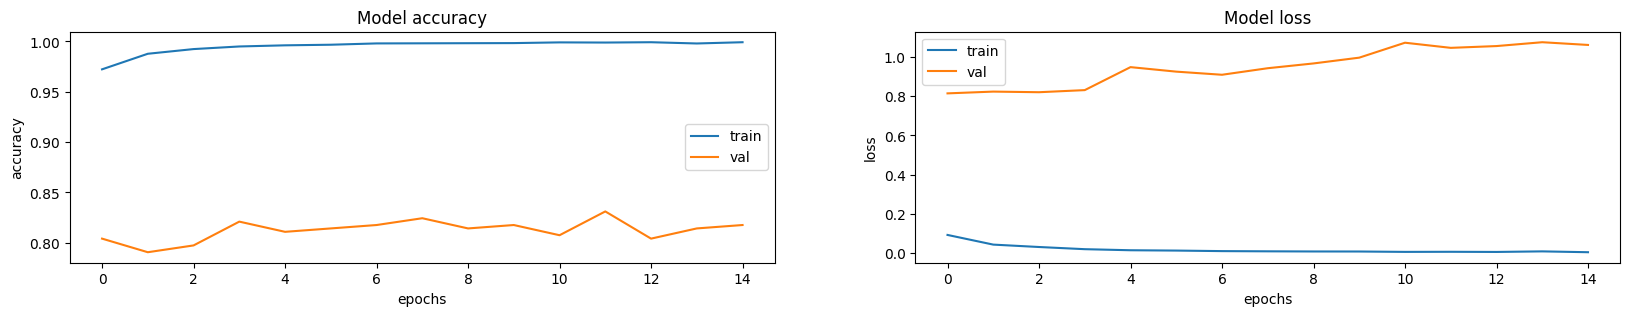

In [36]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(res_model_v2.history.history[metric])
    plt.plot(res_model_v2.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = res_model_v2.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

<div style='text-align: justify; font-family:TimesNewRoman'>
Then, the inference on the last iteration of the from-scratch model (i.e. the one from step 1):
</div>

78/78 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6455 - loss: 2.7233
The test loss is 2.7233, the test accuracy is 0.6455.


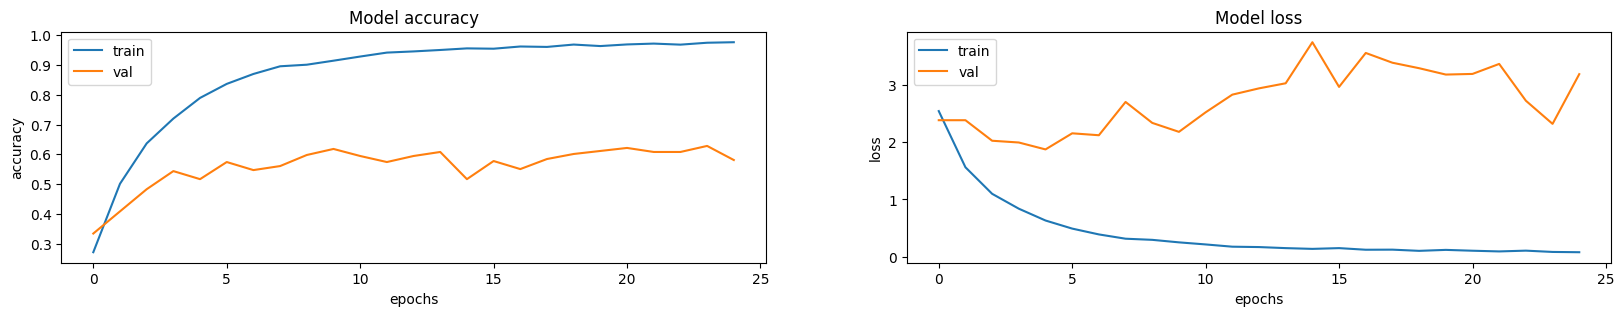

In [37]:
plt.figure(figsize=(20, 3))
for i, metric in enumerate(["accuracy", "loss"]):
    plt.subplot(1, 2, i + 1) 
    plt.plot(model_v3.history.history[metric])
    plt.plot(model_v3.history.history["val_" + metric])
    plt.title("Model {}".format(metric))
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(["train", "val"])

test_loss, test_metric = model_v3.evaluate(X_test, y_test, verbose = 1)
print(f"The test loss is {test_loss:.4f}, the test accuracy is {test_metric:.4f}.")

<div style='text-align: justify; font-family:TimesNewRoman'>
Not surprisingly, the model based on the ResNet-18 architecture achieves the highest accuracy rating on the test dataset. Presumably, this is due to two main reasons:
<ol>
    <li>The number of layers used for feature detection.</li>
    <li>The size of the large-scoped dataset it was trained on (ImageNet-1K has about 1,8 Mln pictures, of which 1,3 Mnl are used for training and 0,5 Mln for validation purposes)</li>
</ol>
The first reason for the performance gap could be easily erased by adapting the from-scratch model to the off-the-shelf one. Despite that, both models display a test accuracy higher than the validation accuracy obtained during steps one and two. Hence, the generalisation capability, even for the from-scratch model, is enough to validate the choices made during the development and refinement of both models.
</div>